In [1]:
import random
import matplotlib.pyplot as plt
import time
import numpy as np 

amountOfLocations = None
locations = []
cars = None
depot = None

def generate_locations(n, bounds=(0,100), seed=None):
    if seed is not None:
        rnd = random.Random(seed)
        return [(rnd.randint(bounds[0], bounds[1]), rnd.randint(bounds[0], bounds[1])) for _ in range(n)]
    return [(random.randint(bounds[0], bounds[1]), random.randint(bounds[0], bounds[1])) for _ in range(n)]

def make_scenarios(seed=None):
    s = 0 if seed is None else seed
    return [
        {"id":"small-1", "num_vehicles":3,  "num_customers":12, "customers": generate_locations(12, seed=s+1)},
        {"id":"small-2", "num_vehicles":7,  "num_customers":18, "customers": generate_locations(18, seed=s+2)},
        {"id":"medium-1","num_vehicles":11, "num_customers":20, "customers": generate_locations(20, seed=s+3)},
        {"id":"medium-2","num_vehicles":15, "num_customers":28, "customers": generate_locations(28, seed=s+4)},
        {"id":"large-1", "num_vehicles":26, "num_customers":30, "customers": generate_locations(30, seed=s+5)},
        {"id":"large-2", "num_vehicles":30, "num_customers":40, "customers": generate_locations(40, seed=s+6)},
    ]

In [2]:
def distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def applay_scenario(scenario_configuration):
    """
    FIX: Setup scenario with normalization baseline computation
    Establishes naive baseline for fair cross-scenario fitness comparison
    """
    global amountOfLocations, locations, cars, depot, dist_matrix, dist_to_depot, naive_baseline_cost
    
    amountOfLocations = scenario_configuration["num_customers"]
    locations = scenario_configuration["customers"][:]
    cars = scenario_configuration["num_vehicles"]

    depot = scenario_configuration.get("depot", (50,50))
    
    # Precompute distance matrices for computational efficiency
    num_customer_locations = len(locations)
    dist_matrix = np.zeros((num_customer_locations, num_customer_locations))
    for customer_i in range(num_customer_locations):
        for customer_j in range(num_customer_locations):
            if customer_i != customer_j:
                dist_matrix[customer_i][customer_j] = distance(locations[customer_i], locations[customer_j])
    
    dist_to_depot = np.array([distance(depot, locations[customer_idx]) 
                             for customer_idx in range(num_customer_locations)])
    naive_baseline_cost = float(2.0 * np.sum(dist_to_depot))

def compute_normalized_solution_quality(actual_total_distance):
    """"
    Compute normalized fitness a primary solution quality metric
    Higher values indicate better solution quality realative to simple basline. 
    """
    if actual_total_distance == float('inf') or actual_total_distance <= 0:
        return 0.0  
    
    
    basline_cost = globals().get('naive_baseline_cost', None)
    if basline_cost is None or basline_cost  <= 0.0: 
        
        return 1.0/ (1.0+ actual_total_distance)
    
    normalized_quality_score = float(basline_cost/actual_total_distance)
    return normalized_quality_score


def get_vrp_cost_and_routes(individual_permutation, num_available_vehicles):
    num_customers = len(individual_permutation)
    if num_customers == 0:
        return float('inf'), []
    
    
    try:
        customer_to_customer_distances = dist_matrix
        depot_to_customer_distances = dist_to_depot
        if num_customers >= 2:
            consecutive_edge_distances = [customer_to_customer_distances[individual_permutation[i]][individual_permutation[i+1]] 
                                        for i in range(num_customers-1)]
        else:
            consecutive_edge_distances = []  
    except NameError:
        if num_customers >= 2:
            consecutive_edge_distances = [distance(locations[individual_permutation[i]], 
                                                 locations[individual_permutation[i+1]]) 
                                        for i in range(num_customers-1)]
        else:
            consecutive_edge_distances = []
        depot_to_customer_distances = None
    
    
    prefix_distance_sums = np.zeros(num_customers)
    if num_customers >= 2:
        prefix_distance_sums[1:] = np.cumsum(consecutive_edge_distances)
    
    infinity_cost = float('inf')
    min_cost_dp = np.full((num_available_vehicles + 1, num_customers + 1), infinity_cost)
    # Backtrack table: route_split_points[vehicles_used][customers_covered] = where to split routes
    route_split_points = np.full((num_available_vehicles + 1, num_customers + 1), -1, dtype=int)
    min_cost_dp[0][0] = 0  # Base case: 0 vehicles serve 0 customers with 0 cost
   
    for vehicles_used in range(1, num_available_vehicles + 1):
        
        for customers_covered in range(0, num_customers + 1):
            
            for route_start_idx in range(0, customers_covered + 1):
                
            
                if customers_covered == route_start_idx:
                    # Empty route: vehicle stays at depot, contributes 0 to total distance
                    internal_route_distance = 0.0
                    total_route_cost = 0.0 
                else:
                    # Non-empty route: vehicle serves customers route_start_idx to customers_covered-1
                    if customers_covered <= route_start_idx:
                        internal_route_distance = 0.0
                    else:
                        # Sum of distances between consecutive customers in this route segment
                        internal_route_distance = (prefix_distance_sums[customers_covered-1] - 
                                                 prefix_distance_sums[route_start_idx])
                    
                    first_customer_idx = individual_permutation[route_start_idx]
                    last_customer_idx = individual_permutation[customers_covered-1]
                    
                    if depot_to_customer_distances is not None:
                        # Total route cost: depot→first + internal + last→depot
                        total_route_cost = (depot_to_customer_distances[first_customer_idx] + 
                                          internal_route_distance + 
                                          depot_to_customer_distances[last_customer_idx])
                    else:
                        total_route_cost = (distance(depot, locations[first_customer_idx]) + 
                                          internal_route_distance + 
                                          distance(locations[last_customer_idx], depot))
                
                # Check if using this route improves the solution
                new_total_cost = min_cost_dp[vehicles_used-1][route_start_idx] + total_route_cost
                if new_total_cost < min_cost_dp[vehicles_used][customers_covered]:
                    min_cost_dp[vehicles_used][customers_covered] = new_total_cost
                    route_split_points[vehicles_used][customers_covered] = route_start_idx
    
    optimal_total_distance = min_cost_dp[num_available_vehicles][num_customers]
    if optimal_total_distance == infinity_cost:
        return infinity_cost, []
    
    # Reconstruct optimal routes from backtrack table (excluding empty routes from output)
    reconstructed_routes = []
    current_vehicles = num_available_vehicles
    current_customers = num_customers
    while current_customers > 0 and current_vehicles >= 0:
        split_point = route_split_points[current_vehicles][current_customers]
        if split_point == -1:
            return infinity_cost, []  # Should not happen with fixed DP
        if current_customers - split_point > 0:  # Only include non-empty routes
            route_segment = individual_permutation[split_point:current_customers]
            reconstructed_routes.append(route_segment)
        current_customers = split_point
        current_vehicles -= 1
    reconstructed_routes.reverse()
    return optimal_total_distance, reconstructed_routes

def fitness(individual_permutation):
    actual_total_distance, _ = get_vrp_cost_and_routes(individual_permutation, cars)
    return compute_normalized_solution_quality(actual_total_distance)

def create_individual():
    return random.sample(range(len(locations)), len(locations))


def crossover(parent1, parent2, crossover_probability):
    """Optimized PMX with faster mapping resolution"""
    if random.random() >= crossover_probability:
        return parent1[:] if random.random() < 0.5 else parent2[:]
    
    size = len(parent1)
    cx_point1 = random.randint(0, size - 1)
    cx_point2 = random.randint(0, size - 1)
    if cx_point1 > cx_point2:
        cx_point1, cx_point2 = cx_point2, cx_point1
    
    child = [-1] * size
    child[cx_point1:cx_point2+1] = parent1[cx_point1:cx_point2+1]
    
    # Faster mapping with conflict resolution
    used = set(child[cx_point1:cx_point2+1])  # Track used values
    mapping = {}
    
    # Build mapping only for conflicts
    for i in range(cx_point1, cx_point2 + 1):
        if parent2[i] not in used:
            mapping[parent2[i]] = parent1[i]
    
    # Fill positions with optimized lookup
    for i in range(size):
        if child[i] == -1:
            candidate = parent2[i]
            # Resolve mapping chain with cycle detection
            while candidate in mapping and candidate in used:
                candidate = mapping[candidate]
            child[i] = candidate
            used.add(candidate)
    
    return child


def mutate(individual,mutation_rate):
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(individual)), 2)
        individual[i], individual[j] = individual[j], individual[i]
    return individual

def tournament_selection(fitnesses,k=3):
    indices = random.sample(range(len(fitnesses)), k)
    return max(indices, key=lambda i: fitnesses[i])

def visualize_individual(individual, fitness_value):
    total_dist, routes = get_vrp_cost_and_routes(individual, cars)
    route_str = "\n".join([f"Vehicle {r+1}: depot -> " + " -> ".join(map(str, route)) + " -> depot" for r, route in enumerate(routes)])
    return f"{route_str}\nTotal Distance: {total_dist:.2f} Fitness: {fitness_value:.6f}"

def genetic_algorithm_with_tracking(generations, population_size, mutation_rate, crossover_probability): #added: all parameters
    """
    FIX: Genetic algorithm using normalized solution quality as unified evaluation metric
    Returns evolution series of best normalized quality scores per generation
    """
    current_population = [create_individual() for _ in range(population_size)]
    best_solution_quality_per_generation = []
    num_elite_individuals = 1
    
    current_population_fitness_scores = [fitness(individual) for individual in current_population]
    
    for generation_number in range(generations):
        # Track best solution quality (highest normalized score = best performance)
        best_quality_this_generation = max(current_population_fitness_scores)
        best_solution_quality_per_generation.append(best_quality_this_generation)
        
        # Elite selection based on normalized solution quality
        fitness_ranked_indices = sorted(range(len(current_population)), 
                                       key=lambda idx: current_population_fitness_scores[idx], 
                                       reverse=True)
        elite_individuals = [current_population[idx][:] for idx in fitness_ranked_indices[:num_elite_individuals]]
        
        new_generation_population = []
        # Generate offspring using tournament selection on normalized quality scores
        num_breeding_pairs = (population_size - num_elite_individuals) // 2
        for breeding_iteration in range(num_breeding_pairs):
            #Tournament selection operates on normalized solution quality values
            parent1_index = tournament_selection(current_population_fitness_scores, k=3)
            parent2_index = tournament_selection(current_population_fitness_scores, k=3)
            parent1_individual = current_population[parent1_index]
            parent2_individual = current_population[parent2_index]
            
            offspring1 = crossover(parent1_individual, parent2_individual, crossover_probability) #added: parameter
            offspring2 = crossover(parent2_individual, parent1_individual, crossover_probability) #added: parameter
            new_generation_population.extend([mutate(offspring1, mutation_rate), mutate(offspring2, mutation_rate)]) #added: parameters
        
        # Preserve elite individuals in new generation
        new_generation_population.extend(elite_individuals)
        
        # Handle population size consistency for odd numbers
        while len(new_generation_population) < population_size:
            new_generation_population.append(elite_individuals[0][:])
        
        current_population = new_generation_population[:population_size]
        #Recompute normalized solution quality scores for new population
        current_population_fitness_scores = [fitness(individual) for individual in current_population]
    
    #Return time series of best normalized solution quality values
    return best_solution_quality_per_generation

🌽 No experimental data found. Running QUICK TEST experiment...

=== QUICK TEST: Conservative ===
Running small-1 (V:2, C:6)... done (0.0s)
Running small-2 (V:3, C:8)... done (0.0s)
Running medium-1 (V:3, C:10)... done (0.0s)
Running medium-2 (V:4, C:12)... done (0.0s)
Running large-1 (V:4, C:14)... done (0.0s)
Running large-2 (V:5, C:16)... done (0.0s)

=== QUICK TEST: Balanced ===
Running small-1 (V:2, C:6)... done (0.0s)
Running small-2 (V:3, C:8)... done (0.0s)
Running medium-1 (V:3, C:10)... done (0.0s)
Running medium-2 (V:4, C:12)... done (0.0s)
Running large-1 (V:4, C:14)... done (0.0s)
Running large-2 (V:5, C:16)... done (0.0s)

=== QUICK TEST: Aggressive ===
Running small-1 (V:2, C:6)... done (0.0s)
Running small-2 (V:3, C:8)... done (0.0s)
Running medium-1 (V:3, C:10)... done (0.0s)
Running medium-2 (V:4, C:12)... done (0.0s)
Running large-1 (V:4, C:14)... done (0.0s)
Running large-2 (V:5, C:16)... done (0.0s)
🌽 Quick test experiment completed!

=== AVAILABLE DATA DEBUG ===
Co

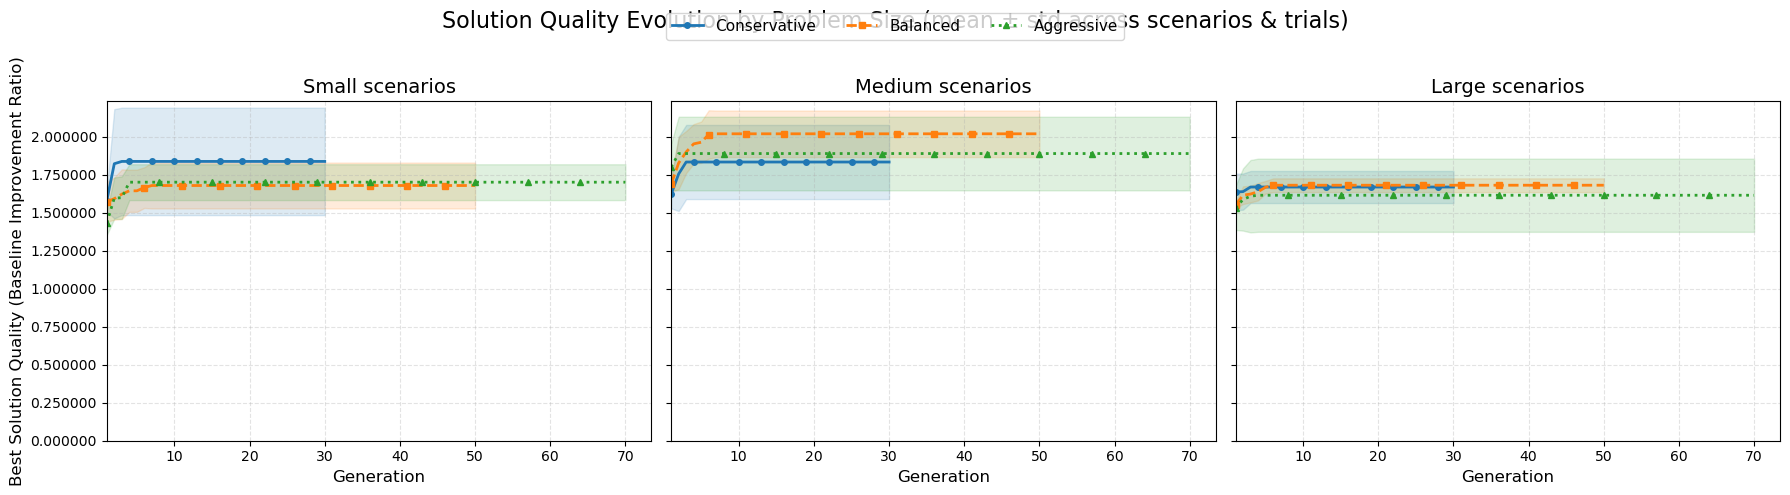

In [3]:
# 🌽🌽 FAST TEST 🌽🌽
# Cleaned single cell: group summary + readable group plots (no duplicates)

if 'parameter_sets' not in globals():
    parameter_sets = [
        {"name":"Conservative","generations":30,"population_size":10,"mutation_rate":0.1,"crossover_probability":0.6},
        {"name":"Balanced","generations":50,"population_size":15,"mutation_rate":0.3,"crossover_probability":0.8},
        {"name":"Aggressive","generations":70,"population_size":20,"mutation_rate":0.5,"crossover_probability":0.9},
    ]

# Initialize variables to avoid "not defined" errors
if 'experimental_results' not in globals():
    experimental_results = {}
if 'timing_performance_results' not in globals():
    timing_performance_results = {}

# FIX: Auto-run quick experiment if no data exists
if (not isinstance(experimental_results, dict) or 
    len(experimental_results) == 0):
    
    print("🌽 No experimental data found. Running QUICK TEST experiment...")
    
    # Quick test parameters (much faster)
    quick_parameter_sets = [
        {"name":"Conservative","generations":5,"population_size":5,"mutation_rate":0.1,"crossover_probability":0.6},
        {"name":"Balanced","generations":7,"population_size":6,"mutation_rate":0.3,"crossover_probability":0.8},
        {"name":"Aggressive","generations":4,"population_size":4,"mutation_rate":0.5,"crossover_probability":0.9},
    ]
    
    # Quick scenarios (smaller problems) - FIX: Include all 6 scenarios for complete testing
    quick_scenarios = [
        {"id":"small-1", "num_vehicles":2,  "num_customers":6, "customers": generate_locations(6, seed=42)},
        {"id":"small-2", "num_vehicles":3,  "num_customers":8, "customers": generate_locations(8, seed=43)},
        {"id":"medium-1","num_vehicles":3, "num_customers":10, "customers": generate_locations(10, seed=44)},
        {"id":"medium-2","num_vehicles":4, "num_customers":12, "customers": generate_locations(12, seed=45)},
        {"id":"large-1", "num_vehicles":4, "num_customers":14, "customers": generate_locations(14, seed=46)},
        {"id":"large-2", "num_vehicles":5, "num_customers":16, "customers": generate_locations(16, seed=47)},
    ]
    
    experimental_results = {}
    timing_performance_results = {}
    num_independent_trials = 2  # Fewer trials for speed
    
    for parameter_configuration in quick_parameter_sets:
        max_generations = parameter_configuration["generations"]
        population_size = parameter_configuration["population_size"]
        mutation_rate = parameter_configuration["mutation_rate"]
        crossover_probability = parameter_configuration["crossover_probability"]
        
        print(f"\n=== QUICK TEST: {parameter_configuration['name']} ===")
        experimental_results[parameter_configuration['name']] = {}
        timing_performance_results[parameter_configuration['name']] = {}
        
        for scenario_config in quick_scenarios:
            scenario_id = scenario_config['id']
            num_vehicles = scenario_config['num_vehicles'] 
            num_customers = scenario_config['num_customers']
            
            print(f"Running {scenario_id} (V:{num_vehicles}, C:{num_customers})...", end="", flush=True)
            applay_scenario(scenario_config)
            
            trial_solution_quality_series = []
            final_solution_quality_scores = []
            trial_execution_times = []
            
            for trial_number in range(num_independent_trials):
                trial_start_time = time.time()
                best_quality_evolution = genetic_algorithm_with_tracking(
                    generations=max_generations,
                    population_size=population_size,
                    mutation_rate=mutation_rate,
                    crossover_probability=crossover_probability
                )
                trial_end_time = time.time()
                trial_duration = trial_end_time - trial_start_time
                
                trial_solution_quality_series.append(best_quality_evolution)
                final_quality_score = best_quality_evolution[-1] if best_quality_evolution else 0.0
                final_solution_quality_scores.append(final_quality_score)
                trial_execution_times.append(trial_duration)
            
            quality_scores_array = np.array(final_solution_quality_scores)
            execution_times_array = np.array(trial_execution_times)
            
            experimental_results[parameter_configuration['name']][scenario_id] = {
                'trials': trial_solution_quality_series,
                'final_fitnesses': final_solution_quality_scores,
                'best': float(np.max(quality_scores_array)),
                'worst': float(np.min(quality_scores_array)),
                'avg': float(np.mean(quality_scores_array)),
                'std': float(np.std(quality_scores_array))
            }
            
            timing_performance_results[parameter_configuration['name']][scenario_id] = {
                'avg_time': float(np.mean(execution_times_array)),
                'std_time': float(np.std(execution_times_array)),
                'trial_times': trial_execution_times
            }
            
            print(f" done ({np.mean(execution_times_array):.1f}s)")
    
    print("🌽 Quick test experiment completed!")

else:
    print("🌽 Using existing experimental data...")

# Groups and visuals
groups = {
    "Small": ["small-1", "small-2"],
    "Medium": ["medium-1", "medium-2"],
    "Large": ["large-1", "large-2"],
}

param_colors = {'Conservative': '#1f77b4', 'Balanced': '#ff7f0e', 'Aggressive': '#2ca02c'}
param_linestyles = {'Conservative': '-', 'Balanced': '--', 'Aggressive': ':'}
param_markers = {'Conservative': 'o', 'Balanced': 's', 'Aggressive': '^'}

# Debug: Check what data is actually available
print("\n=== AVAILABLE DATA DEBUG ===")
for param_name in parameter_sets:
    pname = param_name['name']
    if pname in experimental_results:
        scenarios = list(experimental_results[pname].keys())
        print(f"{pname}: {scenarios}")
    else:
        print(f"{pname}: NO DATA")

# Print nicely aligned summary by group (mirrors run output)
print("\n=== SUMMARY BY GROUP ===")
header = f"{'Group':8} {'ParamSet':12} {'Scenario':10} {'Best':>12} {'Avg':>12} {'Worst':>12} {'Time(s)':>9}"
print(header)
print("-" * len(header))
for gname, sids in groups.items():
    for p in parameter_sets:
        pname = p['name']
        for sid in sids:
            vals = experimental_results.get(pname, {}).get(sid)
            if vals:
                t = timing_performance_results.get(pname, {}).get(sid, {}).get('avg_time', 0.0)
                print(f"{gname:8} {pname:12} {sid:10} {vals['best']:12.6f} {vals['avg']:12.6f} {vals['worst']:12.6f} {t:9.2f}")
            else:
                print(f"{gname:8} {pname:12} {sid:10} {'NO DATA':>12} {'NO DATA':>12} {'NO DATA':>12} {'NO DATA':>9}")
    print("-" * len(header))

# Group-wise plots: mean ± std across scenarios and trials
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
plt.subplots_adjust(wspace=0.25)

for ax, (gname, sids) in zip(axs, groups.items()):
    ax.set_title(f"{gname} scenarios", fontsize=14)
    ax.set_xlabel("Generation", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.35)

    for p in parameter_sets:
        pname = p['name']
        # Skip parameter sets not in experimental results
        if pname not in experimental_results:
            continue
            
        gens = p['generations']
        stacked = []
        for sid in sids:
            entry = experimental_results.get(pname, {}).get(sid)
            if not entry:
                continue
            trials = entry.get('trials', [])
            if not trials:
                continue
            arr = np.array(trials)
            if arr.size == 0:
                continue
            # normalize/truncate/pad to parameter set generations
            if arr.shape[1] > gens:
                arr = arr[:, :gens]
            elif arr.shape[1] < gens:
                pad = np.tile(arr[:, -1:], (1, gens - arr.shape[1]))
                arr = np.concatenate([arr, pad], axis=1)
            stacked.append(arr)

        if not stacked:
            continue
        all_trials = np.vstack(stacked)  # shape (total_trials, gens)
        mean_per_gen = np.mean(all_trials, axis=0)
        std_per_gen = np.std(all_trials, axis=0)
        gens_range = np.arange(1, len(mean_per_gen) + 1)

        ax.plot(gens_range, mean_per_gen, label=pname,
                color=param_colors.get(pname), linestyle=param_linestyles.get(pname), linewidth=2,
                marker=param_markers.get(pname), markersize=4, markevery=max(1, len(gens_range)//10))
        ax.fill_between(gens_range, mean_per_gen - std_per_gen, mean_per_gen + std_per_gen,
                        color=param_colors.get(pname), alpha=0.15)

    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim(left=1)
    ax.set_ylim(bottom=0)
    ax.set_ylabel("")  # shared ylabel set below
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.6f}"))

# shared labels/legend/title
axs[0].set_ylabel("Best Solution Quality (Baseline Improvement Ratio)", fontsize=12)
handles, labels = axs[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.99),
               ncol=min(len(parameter_sets), 4), fontsize=11)
else:
    print("Warning: No legend handles found - no data to plot!")
fig.suptitle("Solution Quality Evolution by Problem Size (mean ± std across scenarios & trials)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

🚀 RUNNING FULL EXPERIMENT FOR ASSIGNMENT REPORT
This will take several minutes but provides correct assignment results...

=== PARAMETER SET: Conservative ===
    Generations=30, Population=10, Mutation=0.1, Crossover=0.6

Running scenario: small-1 (Vehicles: 3, Customers: 12)
  Trial 1/3... completed (0.07s)
  Trial 2/3... completed (0.11s)
  Trial 3/3... completed (0.07s)
  Best quality: 3.393931  Avg quality: 2.716794 ± 0.627726  Time: 0.08s ± 0.02s

Running scenario: small-2 (Vehicles: 7, Customers: 18)
  Trial 1/3... completed (0.30s)
  Trial 2/3... completed (0.30s)
  Trial 3/3... completed (0.30s)
  Best quality: 2.237046  Avg quality: 2.132296 ± 0.077390  Time: 0.30s ± 0.00s

Running scenario: medium-1 (Vehicles: 11, Customers: 20)
  Trial 1/3... completed (0.56s)
  Trial 2/3... completed (0.56s)
  Trial 3/3... completed (0.57s)
  Best quality: 2.265298  Avg quality: 2.047988 ± 0.198608  Time: 0.57s ± 0.00s

Running scenario: medium-2 (Vehicles: 15, Customers: 28)
  Trial 1/3..

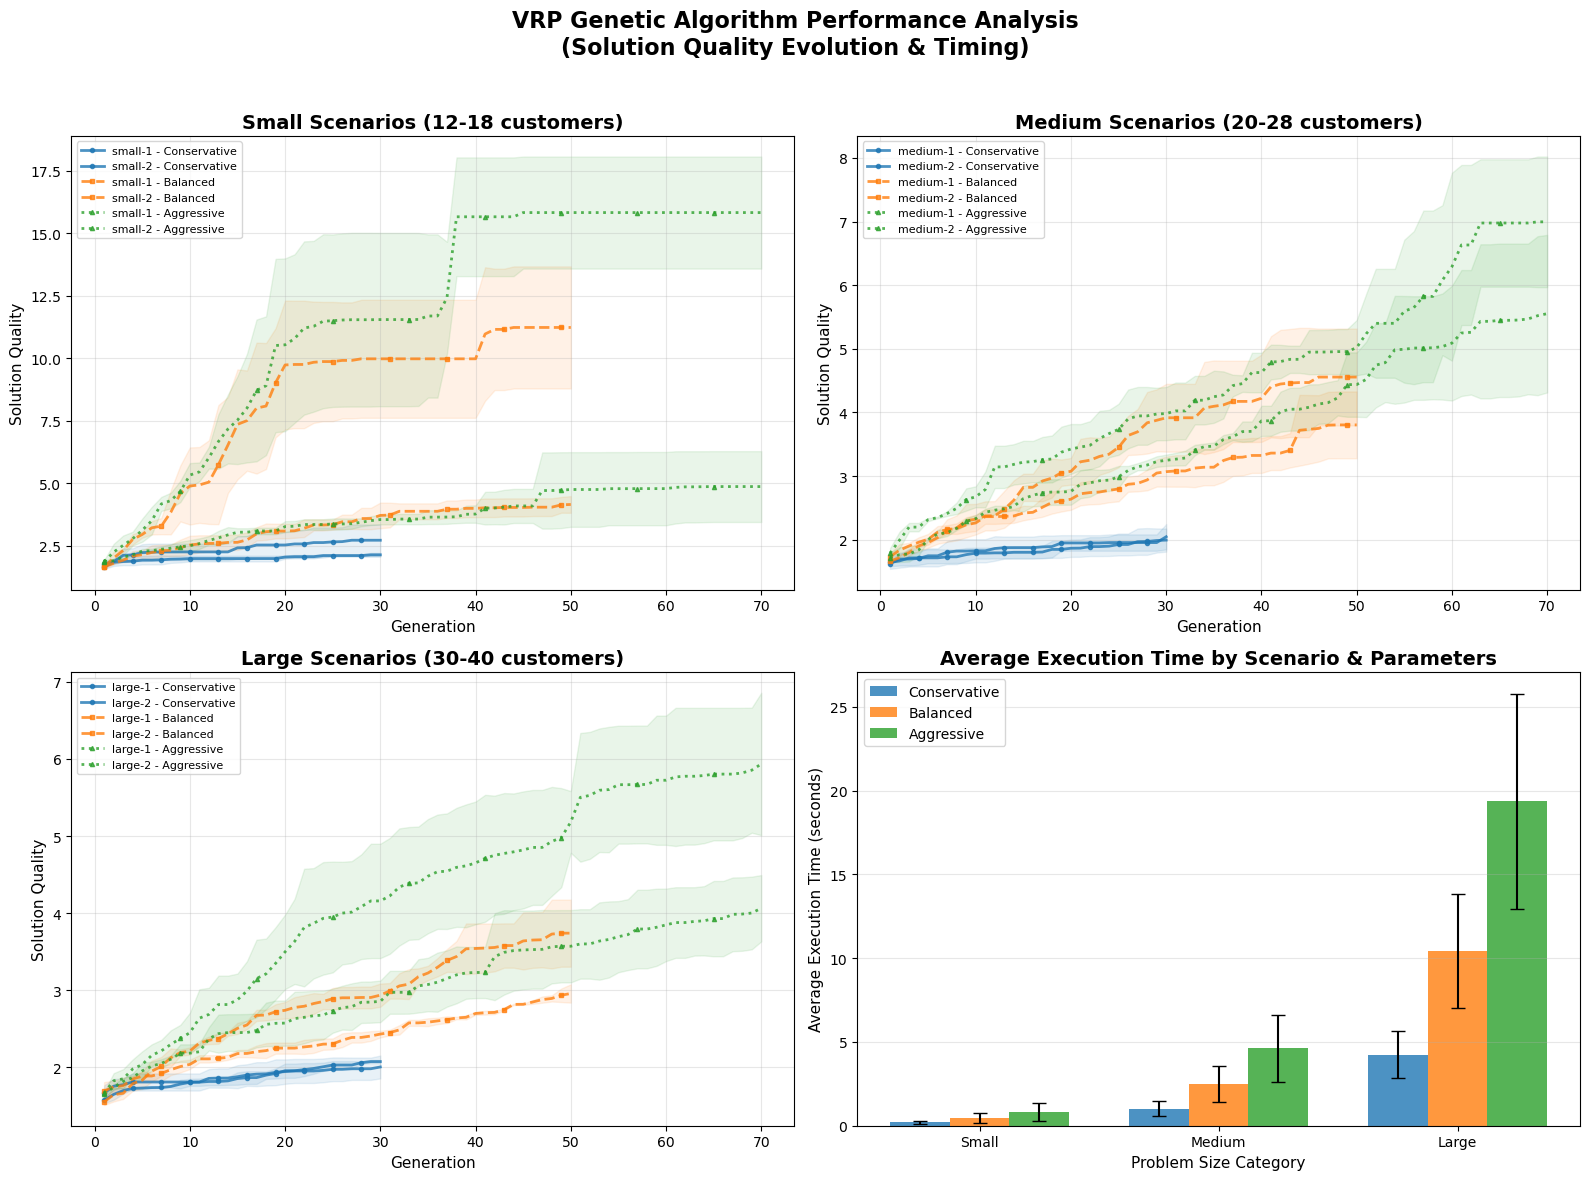


DETAILED TIMING ANALYSIS TABLE (for Report)
Parameter Set   Problem Size Scenario   Avg Time(s)  Std Time(s)  Trials  
--------------------------------------------------------------------------------
Conservative    Small        small-1            0.08         0.02        3
Conservative    Small        small-2            0.30         0.00        3
Conservative    Medium       medium-1           0.57         0.00        3
Conservative    Medium       medium-2           1.47         0.03        3
Conservative    Large        large-1            2.84         0.05        3
Conservative    Large        large-2            5.63         0.03        3
--------------------------------------------------------------------------------
Balanced        Small        small-1            0.16         0.00        3
Balanced        Small        small-2            0.73         0.00        3
Balanced        Medium       medium-1           1.39         0.02        3
Balanced        Medium       medium-2      

In [4]:
def run_full_experiment(parameter_sets=None, num_trials=3, seed=42):
    """
    Run complete VRP experiment with all parameter sets and scenarios.
    Returns experimental_results and timing_performance_results dictionaries.
    """
    if parameter_sets is None:
        parameter_sets = [
            {"name":"Conservative","generations":30,"population_size":10,"mutation_rate":0.1,"crossover_probability":0.6},
            {"name":"Balanced","generations":50,"population_size":15,"mutation_rate":0.3,"crossover_probability":0.8},
            {"name":"Aggressive","generations":70,"population_size":20,"mutation_rate":0.5,"crossover_probability":0.9},
        ]
    
    experimental_results = {}
    timing_performance_results = {}
    scenario_configurations = make_scenarios(seed=seed)
    
    print("🚀 RUNNING FULL EXPERIMENT FOR ASSIGNMENT REPORT")
    print("This will take several minutes but provides correct assignment results...")

    for parameter_configuration in parameter_sets:
        max_generations = parameter_configuration["generations"]
        population_size = parameter_configuration["population_size"]
        mutation_rate = parameter_configuration["mutation_rate"]
        crossover_probability = parameter_configuration["crossover_probability"]

        print(f"\n=== PARAMETER SET: {parameter_configuration['name']} ===")
        print(f"    Generations={max_generations}, Population={population_size}, Mutation={mutation_rate}, Crossover={crossover_probability}")
        
        experimental_results[parameter_configuration['name']] = {}
        timing_performance_results[parameter_configuration['name']] = {}

        for scenario_config in scenario_configurations:
            scenario_id = scenario_config['id']
            num_vehicles = scenario_config['num_vehicles'] 
            num_customers = scenario_config['num_customers']
            
            print(f"\nRunning scenario: {scenario_id} (Vehicles: {num_vehicles}, Customers: {num_customers})")
            applay_scenario(scenario_config)

            trial_solution_quality_series = []
            final_solution_quality_scores = []
            trial_execution_times = []

            for trial_number in range(num_trials):
                print(f"  Trial {trial_number+1}/{num_trials}...", end="", flush=True)
                trial_start_time = time.time()
                
                best_quality_evolution = genetic_algorithm_with_tracking(
                    generations=max_generations,
                    population_size=population_size,
                    mutation_rate=mutation_rate,
                    crossover_probability=crossover_probability
                )
                
                trial_end_time = time.time()
                trial_duration = trial_end_time - trial_start_time
                
                trial_solution_quality_series.append(best_quality_evolution)
                final_quality_score = best_quality_evolution[-1] if best_quality_evolution else 0.0
                final_solution_quality_scores.append(final_quality_score)
                trial_execution_times.append(trial_duration)
                print(f" completed ({trial_duration:.2f}s)")

            quality_scores_array = np.array(final_solution_quality_scores)
            execution_times_array = np.array(trial_execution_times)
            
            experimental_results[parameter_configuration['name']][scenario_id] = {
                'trials': trial_solution_quality_series,
                'final_fitnesses': final_solution_quality_scores,
                'best': float(np.max(quality_scores_array)),
                'worst': float(np.min(quality_scores_array)),
                'avg': float(np.mean(quality_scores_array)),
                'std': float(np.std(quality_scores_array))
            }
            
            timing_performance_results[parameter_configuration['name']][scenario_id] = {
                'avg_time': float(np.mean(execution_times_array)),
                'std_time': float(np.std(execution_times_array)),
                'trial_times': trial_execution_times
            }

            print(f"  Best quality: {experimental_results[parameter_configuration['name']][scenario_id]['best']:.6f}  " +
                  f"Avg quality: {experimental_results[parameter_configuration['name']][scenario_id]['avg']:.6f} ± {experimental_results[parameter_configuration['name']][scenario_id]['std']:.6f}  " +
                  f"Time: {timing_performance_results[parameter_configuration['name']][scenario_id]['avg_time']:.2f}s ± {timing_performance_results[parameter_configuration['name']][scenario_id]['std_time']:.2f}s")

    print("\n✅ FULL EXPERIMENT COMPLETED!")
    return experimental_results, timing_performance_results

def print_fitness_summary_table(experimental_results, parameter_sets):
    """Print clean fitness scores summary table for report analysis."""
    print("\n" + "="*85)
    print("FITNESS SCORES SUMMARY TABLE (for Report Analysis)")
    print("="*85)
    print(f"{'Group':8} {'ParamSet':12} {'Scenario':10} {'Best':>12} {'Avg':>12} {'Worst':>12} {'Std Dev':>12}")
    print("-" * 85)

    scenario_groups = [
        ('Small', ['small-1', 'small-2']),
        ('Medium', ['medium-1', 'medium-2']), 
        ('Large', ['large-1', 'large-2'])
    ]

    for group_name, scenarios in scenario_groups:
        for param_config in parameter_sets:
            param_name = param_config['name']
            for scenario_id in scenarios:
                if (param_name in experimental_results and 
                    scenario_id in experimental_results[param_name]):
                    stats = experimental_results[param_name][scenario_id]
                    print(f"{group_name:8} {param_name:12} {scenario_id:10} "
                          f"{stats['best']:12.6f} {stats['avg']:12.6f} "
                          f"{stats['worst']:12.6f} {stats['std']:12.6f}")
                else:
                    print(f"{group_name:8} {param_name:12} {scenario_id:10} "
                          f"{'NO DATA':>12} {'NO DATA':>12} {'NO DATA':>12} {'NO DATA':>12}")
        print("-" * 85)

def plot_experimental_results(experimental_results, timing_performance_results, parameter_sets):
    """Create comprehensive visualization of experimental results."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # Define colors and styles for consistency
    param_colors = {'Conservative': '#1f77b4', 'Balanced': '#ff7f0e', 'Aggressive': '#2ca02c'}
    param_linestyles = {'Conservative': '-', 'Balanced': '--', 'Aggressive': ':'}
    param_markers = {'Conservative': 'o', 'Balanced': 's', 'Aggressive': '^'}

    # Helper function to plot scenario group
    def plot_scenario_group(ax, title, scenarios):
        ax.set_title(title, fontsize=14, fontweight='bold')
        for param_config in parameter_sets:
            param_name = param_config['name']
            if param_name in experimental_results:
                for scenario_id in scenarios:
                    if scenario_id in experimental_results[param_name]:
                        trial_series = experimental_results[param_name][scenario_id]['trials']
                        if trial_series:
                            trial_array = np.array(trial_series)
                            mean_quality = np.mean(trial_array, axis=0)
                            std_quality = np.std(trial_array, axis=0)
                            gens_range = range(1, len(mean_quality) + 1)
                            
                            label = f"{scenario_id} - {param_name}"
                            ax.plot(gens_range, mean_quality, 
                                    color=param_colors[param_name], 
                                    linestyle=param_linestyles[param_name],
                                    marker=param_markers[param_name],
                                    markersize=3, markevery=max(1, len(gens_range)//8),
                                    label=label, linewidth=2, alpha=0.8)
                            ax.fill_between(gens_range, mean_quality - std_quality, mean_quality + std_quality,
                                            color=param_colors[param_name], alpha=0.1)

        ax.set_xlabel('Generation', fontsize=11)
        ax.set_ylabel('Solution Quality', fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

    # Plot scenario groups
    plot_scenario_group(ax1, 'Small Scenarios (12-18 customers)', ['small-1', 'small-2'])
    plot_scenario_group(ax2, 'Medium Scenarios (20-28 customers)', ['medium-1', 'medium-2'])
    plot_scenario_group(ax3, 'Large Scenarios (30-40 customers)', ['large-1', 'large-2'])

    # Subplot 4: Execution Time Comparison
    ax4.set_title('Average Execution Time by Scenario & Parameters', fontsize=14, fontweight='bold')
    scenario_groups_dict = {'Small': ['small-1', 'small-2'], 'Medium': ['medium-1', 'medium-2'], 'Large': ['large-1', 'large-2']}
    x_pos = np.arange(len(scenario_groups_dict))
    width = 0.25

    for i, param_config in enumerate(parameter_sets):
        param_name = param_config['name']
        avg_times = []
        std_times = []
        
        for group_name, scenarios in scenario_groups_dict.items():
            group_times = []
            for scenario_id in scenarios:
                if (param_name in timing_performance_results and 
                    scenario_id in timing_performance_results[param_name]):
                    group_times.append(timing_performance_results[param_name][scenario_id]['avg_time'])
            
            if group_times:
                avg_times.append(np.mean(group_times))
                std_times.append(np.std(group_times))
            else:
                avg_times.append(0)
                std_times.append(0)
        
        ax4.bar(x_pos + i * width, avg_times, width, 
               yerr=std_times, capsize=5,
               label=param_name, color=param_colors[param_name], alpha=0.8)

    ax4.set_xlabel('Problem Size Category', fontsize=11)
    ax4.set_ylabel('Average Execution Time (seconds)', fontsize=11)
    ax4.set_xticks(x_pos + width)
    ax4.set_xticklabels(scenario_groups_dict.keys())
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3, axis='y')

    # Overall title
    fig.suptitle('VRP Genetic Algorithm Performance Analysis\n(Solution Quality Evolution & Timing)', 
                 fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def print_timing_analysis_table(timing_performance_results, parameter_sets):
    """Print detailed timing analysis table for report."""
    print("\n" + "="*80)
    print("DETAILED TIMING ANALYSIS TABLE (for Report)")
    print("="*80)
    print(f"{'Parameter Set':15} {'Problem Size':12} {'Scenario':10} {'Avg Time(s)':12} {'Std Time(s)':12} {'Trials':8}")
    print("-" * 80)

    for param_config in parameter_sets:
        param_name = param_config['name']
        if param_name in timing_performance_results:
            for group_name, scenarios in [('Small', ['small-1', 'small-2']), 
                                         ('Medium', ['medium-1', 'medium-2']), 
                                         ('Large', ['large-1', 'large-2'])]:
                for scenario_id in scenarios:
                    if scenario_id in timing_performance_results[param_name]:
                        stats = timing_performance_results[param_name][scenario_id]
                        print(f"{param_name:15} {group_name:12} {scenario_id:10} {stats['avg_time']:12.2f} {stats['std_time']:12.2f} {len(stats['trial_times']):8}")
            print("-" * 80)

    # Summary statistics
    print("\nSUMMARY STATISTICS")
    print("="*50)
    for param_config in parameter_sets:
        param_name = param_config['name']
        if param_name in timing_performance_results:
            all_times = []
            for scenario_times in timing_performance_results[param_name].values():
                all_times.extend(scenario_times['trial_times'])
            
            if all_times:
                print(f"{param_name:15}: Avg={np.mean(all_times):6.2f}s, Min={np.min(all_times):6.2f}s, Max={np.max(all_times):6.2f}s")

# MAIN EXECUTION - Now much cleaner!
if __name__ == "__main__" or True:  # Run in Jupyter
    # Define parameter sets
    parameter_sets = [
        {"name":"Conservative","generations":30,"population_size":10,"mutation_rate":0.1,"crossover_probability":0.6},
        {"name":"Balanced","generations":50,"population_size":15,"mutation_rate":0.3,"crossover_probability":0.8},
        {"name":"Aggressive","generations":70,"population_size":20,"mutation_rate":0.5,"crossover_probability":0.9},
    ]
    
    # Run full experiment
    experimental_results, timing_performance_results = run_full_experiment(
        parameter_sets=parameter_sets, 
        num_trials=3, 
        seed=42
    )
    
    # Generate all reports and visualizations
    print_fitness_summary_table(experimental_results, parameter_sets)
    plot_experimental_results(experimental_results, timing_performance_results, parameter_sets)
    print_timing_analysis_table(timing_performance_results, parameter_sets)